#**Desafío - Máquinas de Soporte Vectorial**

##_17 de octubre de 2021_

##**Francisca Pinto**

###**Ejercicio 1**

1. Se inicia importando DataFrame y eliminando columnas solicitadas con <code>.drop()</code>.

In [1]:
!pip install ipython-autotime

In [2]:
#tiempo de ejecución
%load_ext autotime

#dataframe y arrays
import pandas as pd
import numpy as np

#estadística
import scipy.stats as stats

#gráficos

import matplotlib.pyplot as plt
import seaborn as sns

#gama matplotlib para facilitar escritura de código
%matplotlib inline


#separación entrenamiento validación
from sklearn.model_selection import train_test_split, GridSearchCV

#pipeline
from sklearn.pipeline import Pipeline

#clasificadores
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

#preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer, PolynomialFeatures

#SVM
from sklearn.svm import SVC

time: 949 ms (started: 2021-10-17 18:59:16 +00:00)


In [3]:
#AUX: montar archivos y carpetas desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 30.7 s (started: 2021-10-17 18:59:17 +00:00)


In [4]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (5,5) #escalar gráficos
plt.rcParams["figure.dpi"] = 150 #DPI gráficos (también modifica tamaño)

time: 21 ms (started: 2021-10-17 18:59:48 +00:00)


In [5]:
#apertura de archivo.csv en Colab

path_colab = "/content/drive/MyDrive/ADL/3_Intro ML/Desafío 5 - SVM/breast_cancer.csv"
df = pd.read_csv(path_colab)
df.drop(columns = ["Unnamed: 32", "id"], inplace = True) #quitar columna automática y reemplazar df
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


time: 2.41 s (started: 2021-10-17 18:59:48 +00:00)


###**Ejercicio 2**

1. Se aplica <code>LabelEncoder()</code> a <code>diagnosis</code> para decodificar el vector objetivo numéricamente.
2. Posteriormente se separa el DataFrame con <code>train_test_split</code> en sección de entrenamiento y validación.
3. Se grafica la distribución de las variables segmentando según <code>diagnosis</code>.

In [6]:
le = LabelEncoder()
df[["diagnosis"]] = df[["diagnosis"]].apply(le.fit_transform)

time: 11.4 ms (started: 2021-10-17 18:59:51 +00:00)


In [7]:
df.shape #para corroborar

(569, 31)

time: 4.07 ms (started: 2021-10-17 18:59:51 +00:00)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = "diagnosis"),
                                                    df["diagnosis"],
                                                    test_size = 0.33,
                                                    random_state = 3748)

time: 15.1 ms (started: 2021-10-17 18:59:51 +00:00)


In [9]:
std = StandardScaler()
X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.fit_transform(X_test)

time: 9.01 ms (started: 2021-10-17 18:59:51 +00:00)


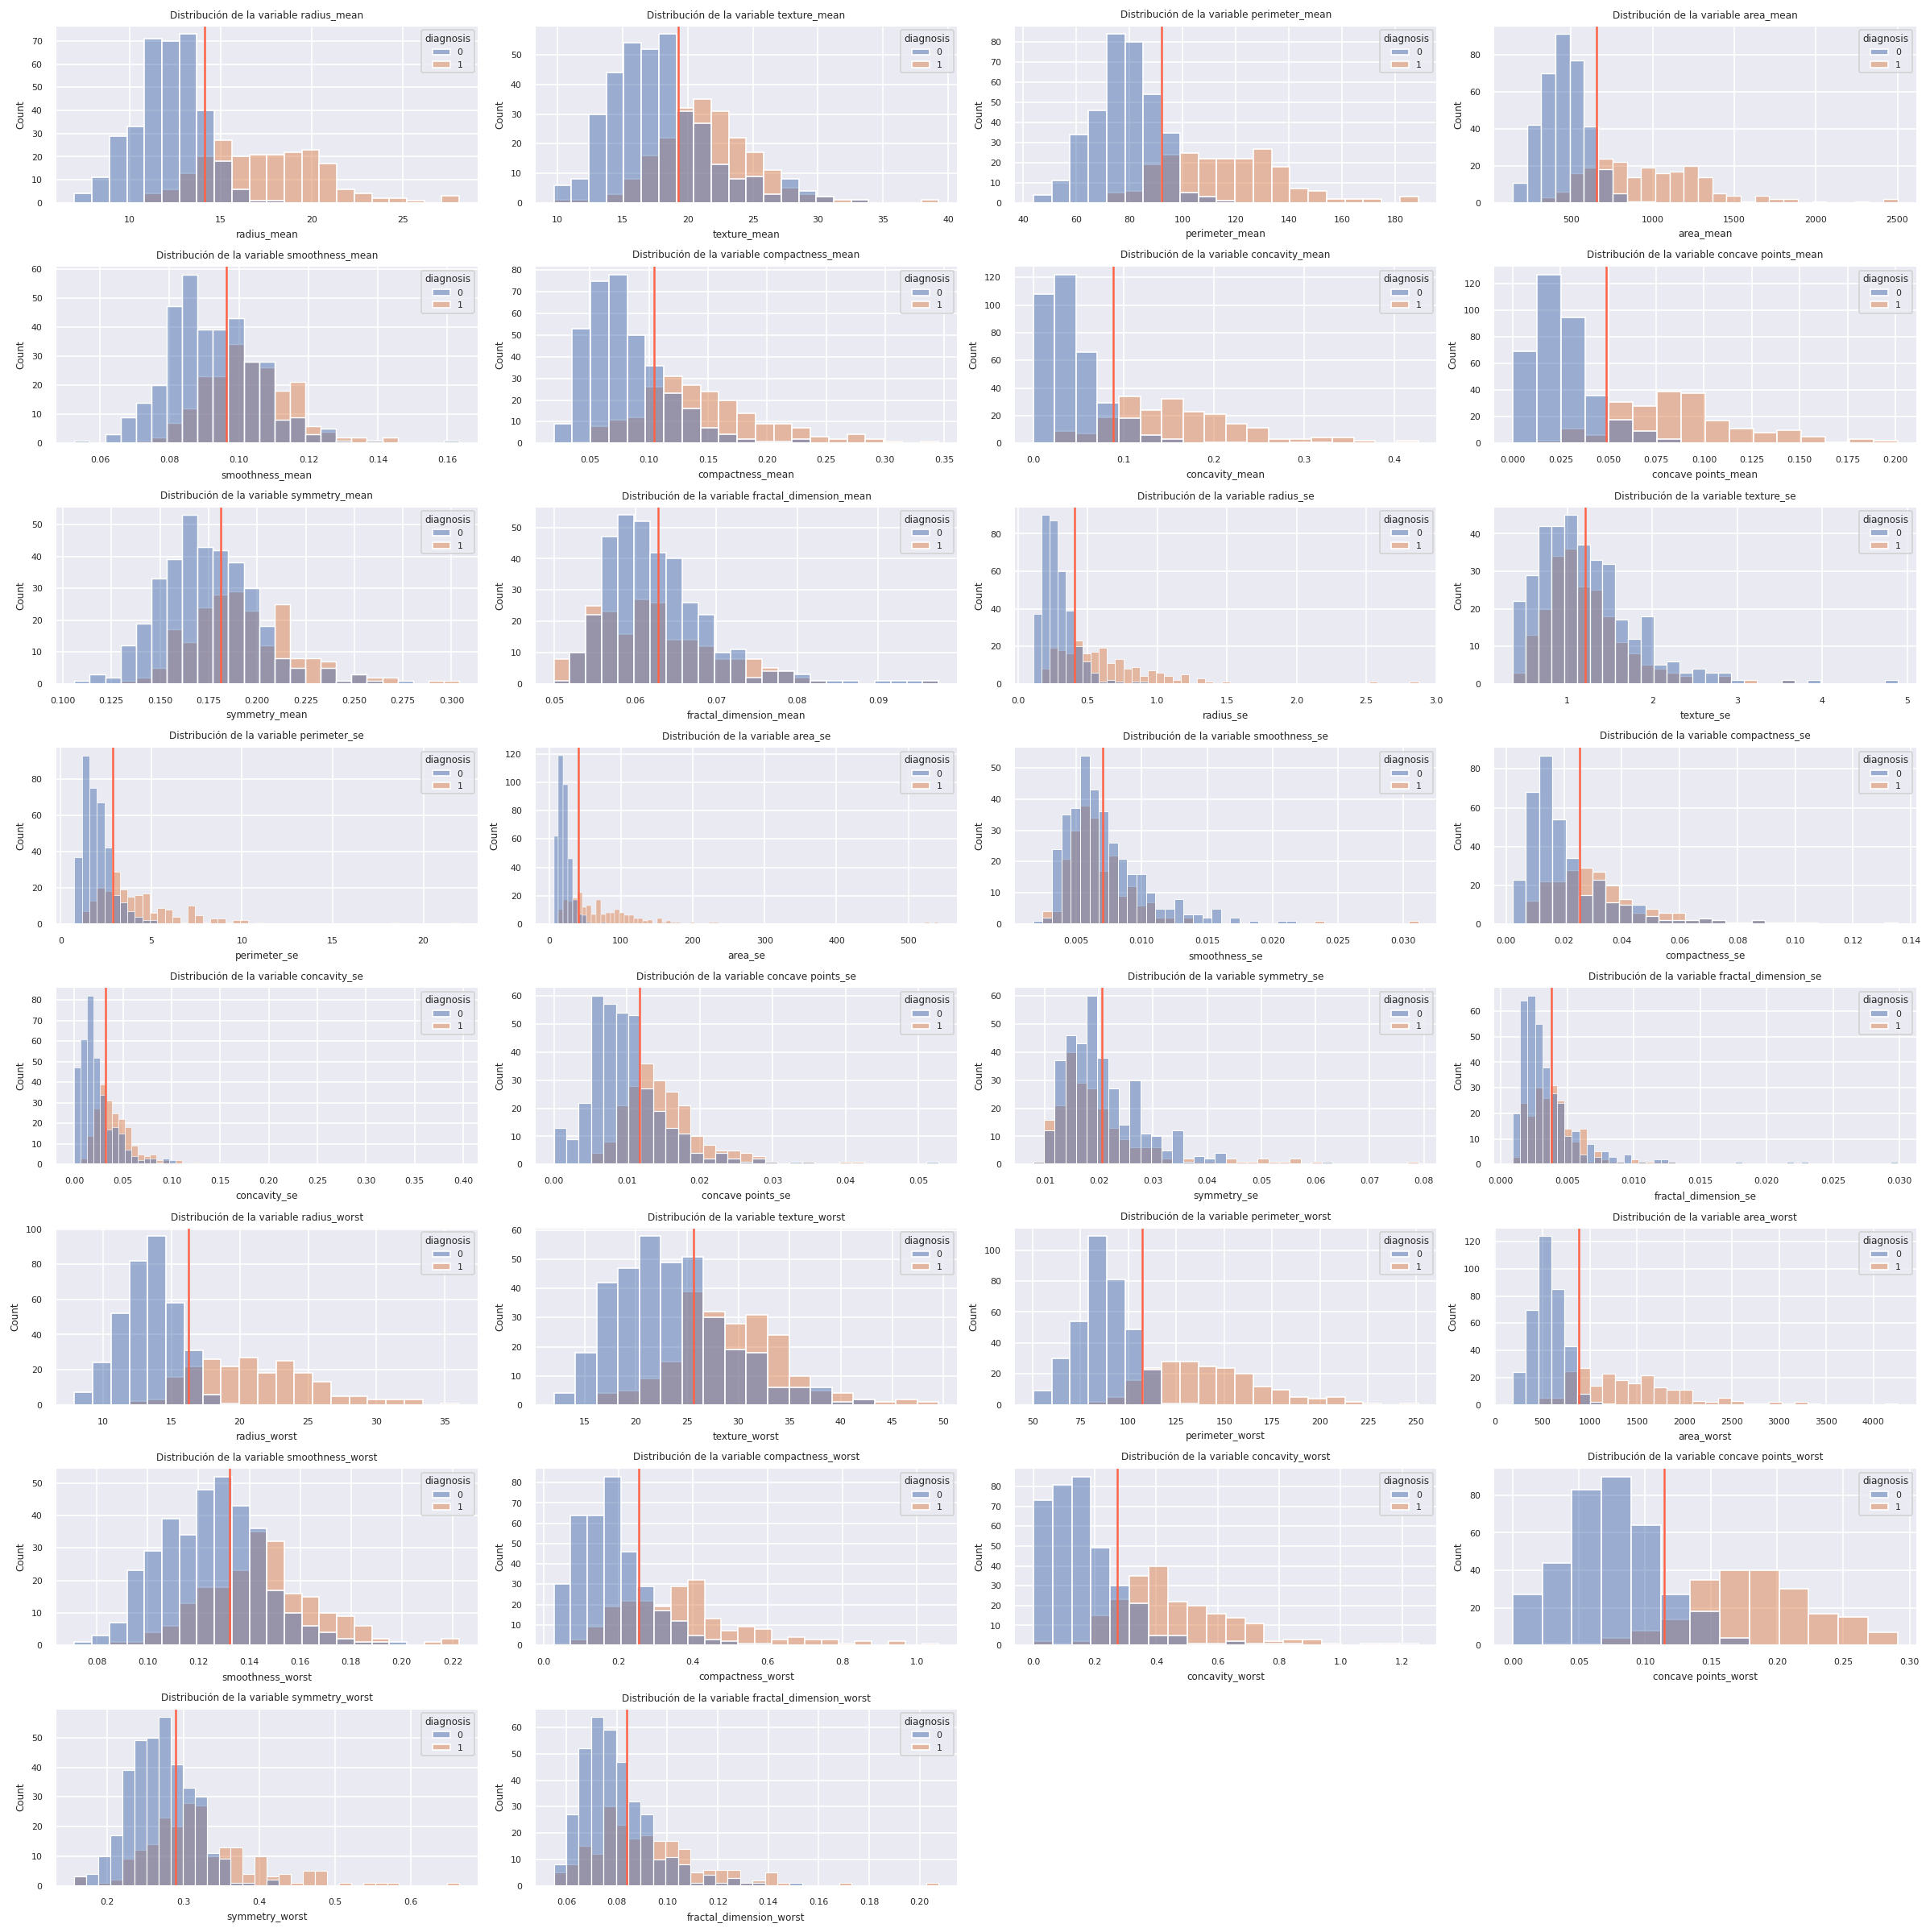

time: 20.5 s (started: 2021-10-17 19:06:38 +00:00)


In [33]:
sns.set(font_scale = 0.6) #escalar fuente para acomodar a gráfico
sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (20, 20) #escalar gráficos
plt.rcParams["figure.dpi"] = 120 #DPI gráficos (también modifica tamaño)

for n, i in enumerate(df.iloc[:, 1:]):
  
  plt.subplot(8, 4, n+1)

  ax = sns.histplot(x = df[i], hue = df["diagnosis"])
  plt.axvline(x = df[i].mean(),
              color = "tomato")

  plt.title(f"Distribución de la variable {i}")

plt.tight_layout()

Comentarios:

1. Los atributos con mayor similitud de distribución, según se observa en los histogramas, son:

* <code>symmetry_mean</code>
* <code>fractal_dimension_mean</code>
* <code>texture_se</code>
* <code>smothness_se</code>
* <code>compactness_se</code>
* <code>symmetry_se</code>
* <code>fractal_dimension_se</code>

2. Esto se realizó por inspección visual pero sin tener una medida clara que permitiera analizar.
3. Para mejorar este análisis se realiza la función entregada y se ve la proporción de la comunalidad entre clases de <code>diagnosis</code> por atributo. Posteriormente se crea un DataFrame con la información calculada por la función.

###**Ejercicio 3**

In [11]:
def histogram_overlap(df, attribute, target, perc = 100):

  empirical_lower_bound = np.floor(df[attribute].min())
  empirical_upper_bound = np.ceil(df[attribute].max())

  tmp_hist_holder = {}

  for unique_value in np.unique(df[target]):

    tmp, _ = np.histogram(df[df[target] == unique_value][attribute],
                          bins = perc,
                          range = [empirical_lower_bound, empirical_upper_bound]
                          )
    
    tmp_hist_holder["h_" + str(unique_value)] = tmp
  
  get_minimum = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
  intersection = np.true_divide(np.sum(get_minimum),
                                np.sum(tmp_hist_holder["h_0"]))
  
  return intersection

time: 13.5 ms (started: 2021-10-17 19:00:11 +00:00)


In [12]:
histogram_overlap(df, "radius_mean", "diagnosis", 100)

0.18487394957983194

time: 7.42 ms (started: 2021-10-17 19:00:11 +00:00)


In [13]:
overlap_number = []
for index, attribute in enumerate(df):
  overlap_number.append(histogram_overlap(df, attribute, "diagnosis", 100))

df_overlap_data = {"Attribute" : df.columns,
        "Overlap_percentage" : overlap_number,
        }

df_overlap = pd.DataFrame(df_overlap_data)

df_overlap.sort_values(by = "Overlap_percentage",
                       ascending = True,
                       inplace = True)

time: 94.9 ms (started: 2021-10-17 19:00:11 +00:00)


In [14]:
df_overlap

,Attribute,Overlap_percentage
0,diagnosis,0.000000
23,perimeter_worst,0.128852
24,area_worst,0.128852
21,radius_worst,0.134454
8,concave points_mean,0.137255
28,concave points_worst,0.140056
3,perimeter_mean,0.168067
4,area_mean,0.179272
7,concavity_mean,0.182073
1,radius_mean,0.184874


time: 19.8 ms (started: 2021-10-17 19:00:11 +00:00)


###**Ejercicio 4**

Comentarios:

2. Se entrenarán modelos con los mejores hiperparámetros entregados con <code>GridSearchCV</code>.
3. Se creará un <code>Heatmap</code> con los puntajes estimados por el método <code>GridSearchCV</code>.

In [15]:
c_gamma_params = {"C" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  "gamma" : [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
                  }

model1 = SVC(kernel = "rbf")

time: 3.03 ms (started: 2021-10-17 19:00:11 +00:00)


In [16]:
grid = GridSearchCV(estimator = model1,
                    param_grid = c_gamma_params,
                    cv = 10,
                    )

grid.fit(X_train_scaled, y_train)
grid_yhat = grid.predict(X_test)

time: 5.24 s (started: 2021-10-17 19:00:11 +00:00)


In [18]:
grid.best_params_

{'C': 10, 'gamma': 0.01}

time: 3.65 ms (started: 2021-10-17 19:00:17 +00:00)


In [19]:
grid.best_score_

0.9763157894736842

time: 3.69 ms (started: 2021-10-17 19:00:17 +00:00)


In [21]:
grid.cv_results_["mean_test_score"] #se accede a este sector del reporte con el nombre "mean_test_score"

array([0.61153846, 0.61153846, 0.61153846, 0.61153846, 0.61153846,
       0.61153846, 0.61153846, 0.61153846, 0.61153846, 0.61153846,
       0.61153846, 0.61153846, 0.61153846, 0.61153846, 0.61153846,
       0.61153846, 0.61153846, 0.61153846, 0.61153846, 0.61153846,
       0.61153846, 0.61153846, 0.61153846, 0.73495277, 0.94224022,
       0.92381916, 0.61153846, 0.61153846, 0.61153846, 0.75337382,
       0.94224022, 0.96578947, 0.94480432, 0.61673414, 0.61153846,
       0.61153846, 0.94487179, 0.97105263, 0.97631579, 0.94480432,
       0.61673414, 0.61153846, 0.61153846, 0.97368421, 0.97105263,
       0.97368421, 0.94480432, 0.61673414, 0.61153846, 0.76120108,
       0.97631579, 0.96585695, 0.96578947, 0.94480432, 0.61673414,
       0.61153846])

time: 5.08 ms (started: 2021-10-17 19:00:17 +00:00)


Text(0.5, 1.0, 'Heatmap de Accuracy de combinaciones C y gamma')

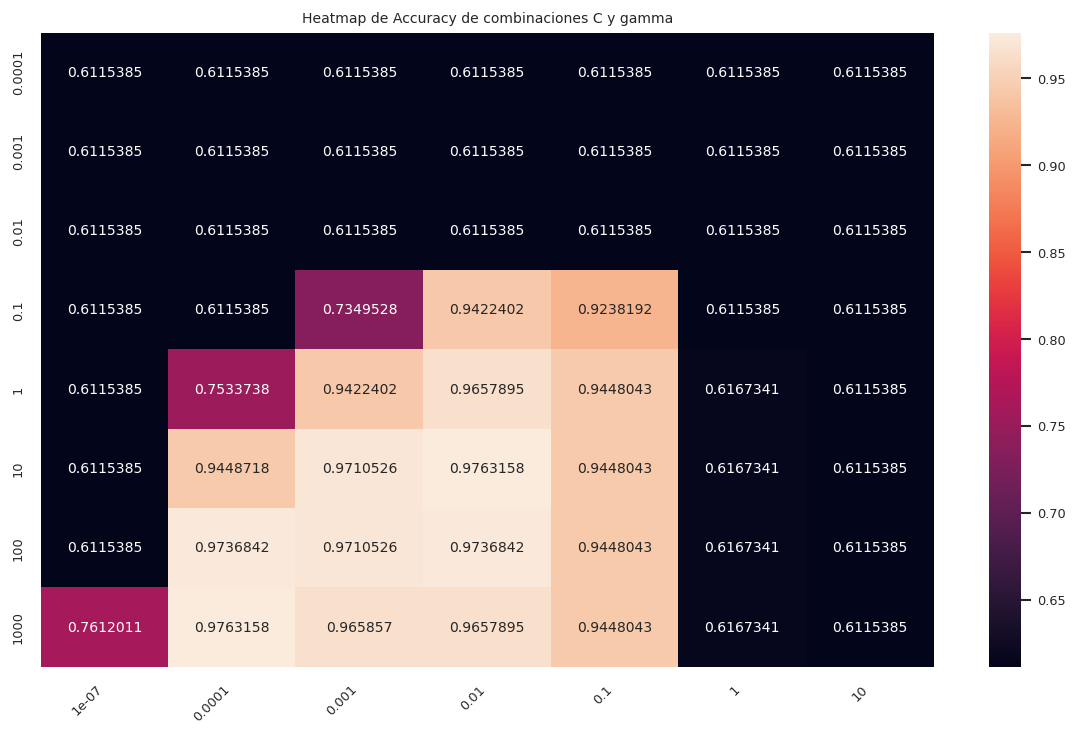

time: 810 ms (started: 2021-10-17 19:00:17 +00:00)


In [22]:
sns.set(font_scale = 0.7) #escalar fuente para acomodar a gráfico
sns.set_style("darkgrid", {"grid.color": "0.8", "grid.linestyle" : ":"})
plt.rcParams["figure.figsize"] = (12, 7) #escalar gráficos
plt.rcParams["figure.dpi"] = 120 #DPI gráficos (también modifica tamaño)

ax = sns.heatmap(grid.cv_results_["mean_test_score"].reshape(8, 7),
                 square = False,
                 annot = True,
                 fmt = ".7g"
)

ax.set_xticklabels(c_gamma_params["gamma"],
                    rotation = 45,
                    horizontalalignment = "right")

ax.set_yticklabels(c_gamma_params["C"]);

plt.title("Heatmap de Accuracy de combinaciones C y gamma")

Comentarios:

1. La mejor combinación de parámetros es con <code>C = 10</code> y <code>Gamma = 0.01</code>.
2. En general, se observa un área óptima entre <code>10 < C < 1000</code> y <code>0.0001 < Gamma < 0.1</code>.
3. Ahora, se toma la mejor combinación de C y Gamma (revisada con el método <code>.best_params_</code>) para aplicar en el modelo ajustado a los datos de validación.


###**Ejercicio 5**


In [23]:
model1.fit(X_train_scaled, y_train)

yhat_model1 = model1.predict(X_test_scaled)

print(classification_report(y_test, yhat_model1))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       124
           1       0.94      0.95      0.95        64

    accuracy                           0.96       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.96      0.96      0.96       188

time: 16.8 ms (started: 2021-10-17 19:00:17 +00:00)


Comentarios:

1. Accuracy ponderada es bastante buena: <code>96%</code>.
2. Los casos con mejor ajuste son los correspondientes a la clase predominante en el DataFrame (<code>diagnosis = 0</code>)
3. Los casos con peor ajuste son los de la clase subrepresentada (<code>diagnosis = 1</code>), sobretodo en la precisión, por lo que el modelo tiende a generar más falsos positivos (en este caso, <code>diagnosis = 1</code> que en realidad son <code>diagnosis = 0</code>). A pesar de ello, es importante notar que las métricas del modelo son todas bastante altas (<code>94%</code> o más)
4. Ahora se realizará modelo solo con atributos con overlap < <code>45%</code>.

###**Ejercicio 6**

1. Se seleccionan las columnas con porcentaje de comunalidad mayor o igual a <code>45%</code>, y se utiliza esta segmentación para eliminar tales atributos en el nuevo DataFrame.
2. Posteriormente se crean nuevas divisiones en matrices de entrenamiento y validación con <code>train_test_split</code>.

In [24]:
df_2_columns = df_overlap[df_overlap["Overlap_percentage"] >= 0.45]["Attribute"]

time: 2.53 ms (started: 2021-10-17 19:00:18 +00:00)


In [25]:
df_2 = df.drop(columns = df_2_columns)

time: 2.6 ms (started: 2021-10-17 19:00:18 +00:00)


In [26]:
df_2

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,radius_worst,texture_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst
0,1,17.99,10.38,122.80,1001.0,0.27760,0.30010,0.14710,1.0950,8.589,153.40,25.380,17.33,184.60,2019.0,0.66560,0.7119,0.2654,0.4601
1,1,20.57,17.77,132.90,1326.0,0.07864,0.08690,0.07017,0.5435,3.398,74.08,24.990,23.41,158.80,1956.0,0.18660,0.2416,0.1860,0.2750
2,1,19.69,21.25,130.00,1203.0,0.15990,0.19740,0.12790,0.7456,4.585,94.03,23.570,25.53,152.50,1709.0,0.42450,0.4504,0.2430,0.3613
3,1,11.42,20.38,77.58,386.1,0.28390,0.24140,0.10520,0.4956,3.445,27.23,14.910,26.50,98.87,567.7,0.86630,0.6869,0.2575,0.6638
4,1,20.29,14.34,135.10,1297.0,0.13280,0.19800,0.10430,0.7572,5.438,94.44,22.540,16.67,152.20,1575.0,0.20500,0.4000,0.1625,0.2364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,142.00,1479.0,0.11590,0.24390,0.13890,1.1760,7.673,158.70,25.450,26.40,166.10,2027.0,0.21130,0.4107,0.2216,0.2060
565,1,20.13,28.25,131.20,1261.0,0.10340,0.14400,0.09791,0.7655,5.203,99.04,23.690,38.25,155.00,1731.0,0.19220,0.3215,0.1628,0.2572
566,1,16.60,28.08,108.30,858.1,0.10230,0.09251,0.05302,0.4564,3.425,48.55,18.980,34.12,126.70,1124.0,0.30940,0.3403,0.1418,0.2218
567,1,20.60,29.33,140.10,1265.0,0.27700,0.35140,0.15200,0.7260,5.772,86.22,25.740,39.42,184.60,1821.0,0.86810,0.9387,0.2650,0.4087


time: 72.4 ms (started: 2021-10-17 19:00:18 +00:00)


In [36]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_2.drop(columns = "diagnosis"),
                                                        df_2["diagnosis"],
                                                        test_size = 0.33,
                                                        random_state = 3748)

time: 7.01 ms (started: 2021-10-17 19:42:46 +00:00)


In [37]:
X_train2_scaled = std.fit_transform(X_train2)
X_test2_scaled = std.fit_transform(X_test2)

time: 17.8 ms (started: 2021-10-17 19:42:49 +00:00)


In [38]:
model2 = SVC(kernel = "rbf")

model2.fit(X_train2_scaled, y_train2)

yhat_model2 = model2.predict(X_test2_scaled)

print(classification_report(y_test2, yhat_model2))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       124
           1       0.95      0.95      0.95        64

    accuracy                           0.97       188
   macro avg       0.96      0.96      0.96       188
weighted avg       0.97      0.97      0.97       188

time: 15.1 ms (started: 2021-10-17 19:44:18 +00:00)


Comentarios:

1. El modelo mejoró su rendimiento: el <code>accuracy</code> ponderado subió a un <code>97%</code>. Por otro lado, la precisión con la clase <code>diagnosis = 1</code> subió en la misma magnitud, igualándose al <code>recall</code>. En la clase <code>diagnosis = 0</code> también subió en un <code>1%</code> el <code>recall</code>. Lo anterior lleva a una mejora en el <code>f1-score</code> de ambas clases.

2. Las mejoras indicadas ocurren dada una disminución en el cálculo de falsos positivos en la clase <code>diagnosis = 1</code> y falsos negativos en la clase <code>diagnosis = 0</code> (mejorando <code>precision</code> y <code>recall</code>, respectivamente).